In [1]:
import torch
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np

from scipy.special import softmax
from sklearn.metrics.pairwise import cosine_similarity

from models.pipeline import Pipeline
from utils.view import draw_grid

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def grid_to_latent(pipeline: Pipeline, grid, model_type="vq"):
    grid = pipeline.preprocess_and_compress(grid)
    if model_type == 'vq':
        z = pipeline.encode(grid.unsqueeze(0).to(device))
    else:
        z, _ = pipeline.encode(grid.unsqueeze(0).to(device))
    
    z_size = z.size()
    z_flat = z.view(z.size(0), -1)

    return z_flat, z_size

def latent_to_grid(pipeline: Pipeline, z, expected_output, model_type="vq"):
    if model_type == 'vq':
        z_quantized, _, _ = pipeline.model.quantize(z.to(device))
        decoded = pipeline.decode(z_quantized)
    else:
        decoded = pipeline.decode(z.unsqueeze(0).to(device))
        
    return pipeline.decompress_and_postprocess(decoded.squeeze(0), expected_output)

def process_train_pairs(pipeline: Pipeline, train_pairs, model_type="vq"):
    z_inputs = []
    z_diffs = []
    z_size = None
    for input, output in train_pairs:
        z_input, z_size = grid_to_latent(pipeline, input, model_type)
        z_output, _ = grid_to_latent(pipeline, output, model_type)
        z_inputs.append(z_input)
        z_diffs.append(z_output - z_input)
    
    return z_inputs, z_diffs, z_size

def extract_diff(z_diffs, z_inputs, z_test_input, comp="average"):
    if comp == 'average':
        return np.mean(z_diffs, axis=0)
    elif comp == 'scaled_euc':
        support_dists = [np.linalg.norm(support_z - z_test_input) for support_z in z_inputs]
        euc_weights = softmax(-np.array(support_dists))
        return np.sum([w * z for w, z in zip(euc_weights, z_diffs)], axis=0)
    elif comp == 'scaled_cos':
        z_inputs = np.array(z_inputs)
        if z_inputs.ndim > 2:
        # Flatten all dimensions after the first one
            z_inputs_2d = z_inputs.reshape(z_inputs.shape[0], -1)
        else:
            z_inputs_2d = z_inputs
            
        if z_test_input.ndim > 1:
            z_test_input_2d = z_test_input.reshape(1, -1)
        else:
            z_test_input_2d = z_test_input.reshape(1, -1)
        

        cos_sims = cosine_similarity(z_inputs_2d, z_test_input_2d).flatten()
        cos_weights = softmax(cos_sims)
        return np.sum([w * z for w, z in zip(cos_weights, z_diffs)], axis=0)
    else:
        return np.zeros_like(z_test_input)

def visual_analogy_single_task(pipeline: Pipeline, train_pairs, test_pair, model_type="vq", comp='average'):
    pipeline.model_eval()

    with torch.no_grad():
        test_input, test_output = test_pair
        z_inputs, z_diffs, z_size = process_train_pairs(pipeline, train_pairs, model_type)
        z_test_input, _ = grid_to_latent(pipeline, test_input, model_type)

        z_diff = extract_diff(z_diffs, z_inputs, z_test_input, comp)
        
        z_pred = z_test_input + z_diff
        z_pred_reshaped = z_pred.view(*z_size)
        
        predicted_output = latent_to_grid(pipeline, z_pred_reshaped, test_output, model_type)
    return predicted_output, test_output


In [2]:
import random

# from models.convolutional_vqvae import ConvolutionalVQVAE, preprocess_grid, postprocess_grid
from models.convolutional_vae import ConvolutionalVAE, preprocess_grid, postprocess_grid
# from models.convolutional_vae_v2 import ConvolutionalVAEV2, preprocess_grid, postprocess_grid
# from models.fully_connected_vae import FullyConnectedVAE
# from models.vq_pipeline import preprocess_grid, postprocess_grid, get_compression_functions


# SEED = 42
# torch.manual_seed(SEED)
# np.random.seed(SEED)
# random.seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ConvolutionalVAE(
        in_channels=10, 
        num_filters=128, 
        latent_dim=128,
        feature_dim=[2, 2]
    ).to(device)

# model = ConvolutionalVQVAE(
#     in_channels=10, 
#     starting_filters=64, 
#     num_embeddings=256,
#     embedding_dim=64,
#     commitment_cost=0.1
# ).to(device)

# model = ConvolutionalVAEV2(
#     in_channels=10, 
#     starting_filters=64, 
#     latent_dim=128,
#     feature_dim=[8, 8]
# ).to(device)

# model = FullyConnectedVAE(
#     input_dim=64*6*6,
#     hidden_dim=1024,
#     latent_dim=64
# ).to(device)

# checkpoint = torch.load('../../checkpoints/conv_vqvae_batchnorm_6x6x64.pt', map_location=device)
# checkpoint = torch.load('../../checkpoints/conv_vaev2_bacthnorm_lat128_beta05.pt', map_location=device)
# checkpoint = torch.load('../../checkpoints/vqvae_vae_64.pt', map_location=device)
checkpoint = torch.load('../../checkpoints/conv_vae_batchnorm_lat128.pt', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])

# compress_fn, decompress_fn = get_compression_functions('../../checkpoints/conv_vqvae_batchnorm_6x6x64.pt')

pipeline = Pipeline(
    model=model,
    preprocess_fn=preprocess_grid,
    postprocess_fn=postprocess_grid,
    # compress_fn=compress_fn,
    # decompress_fn=decompress_fn,
)

In [3]:
from utils.load_data import get_grids

data, _  = get_grids(filepath="../../data/evaluation", split=False)

average


/var/folders/x_/1hf63s3j2m7bc3xtjhjglm780000gn/T/ipykernel_48797/3099429816.py:84: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  z_pred = z_test_input + z_diff


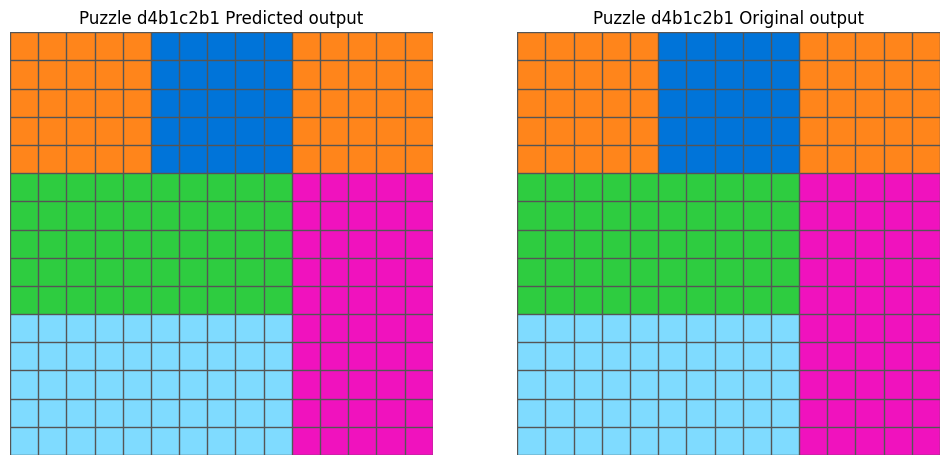

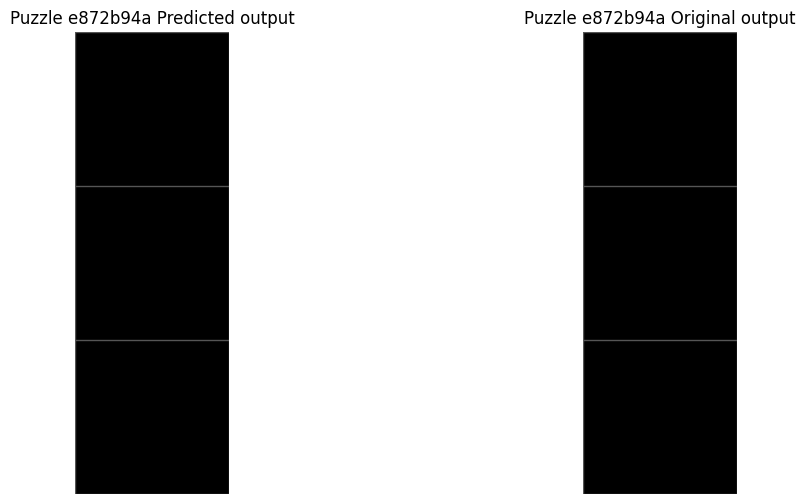

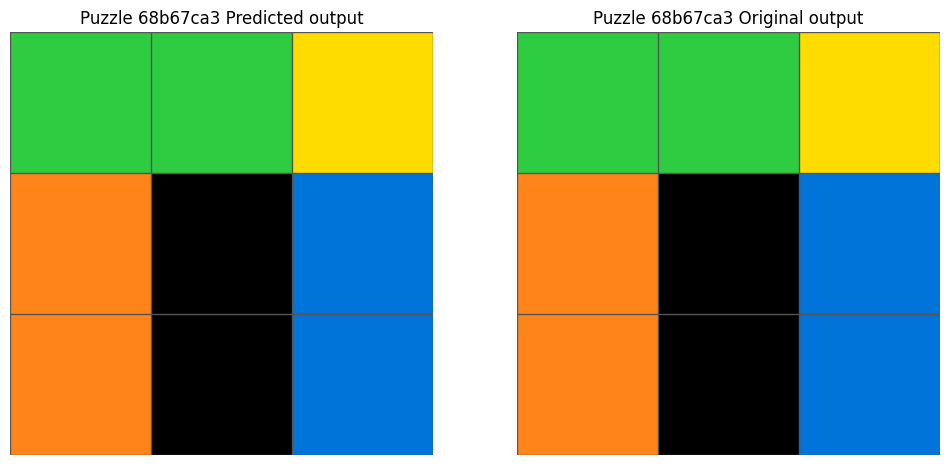

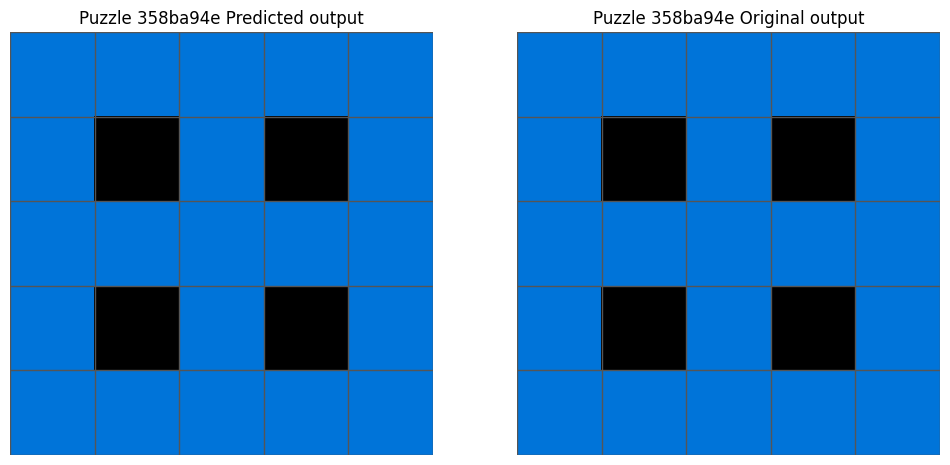

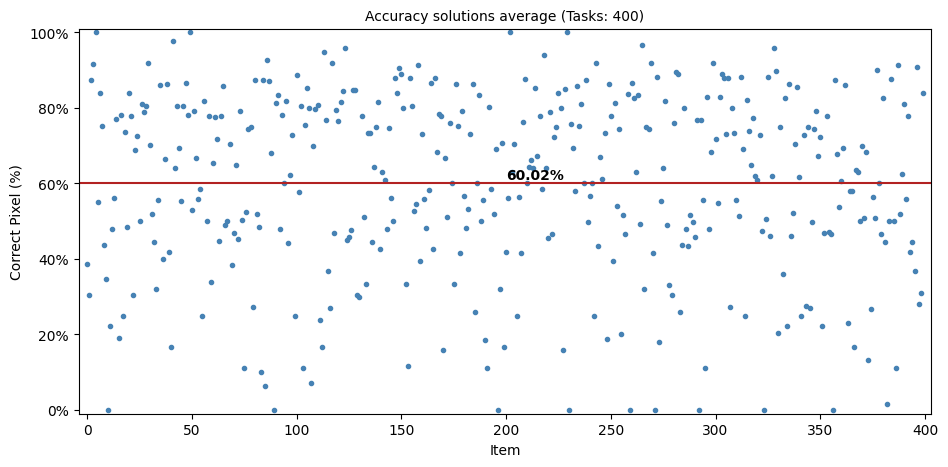

Number of 100% Correct: 4
Number of 90%+ Correct: 22
Number of 80%+ Correct: 99
Number of 70%+ Correct: 170
scaled_euc


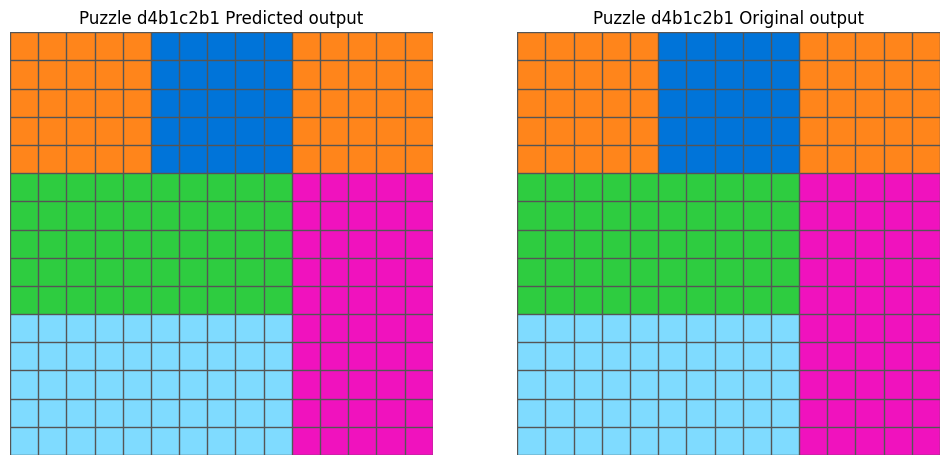

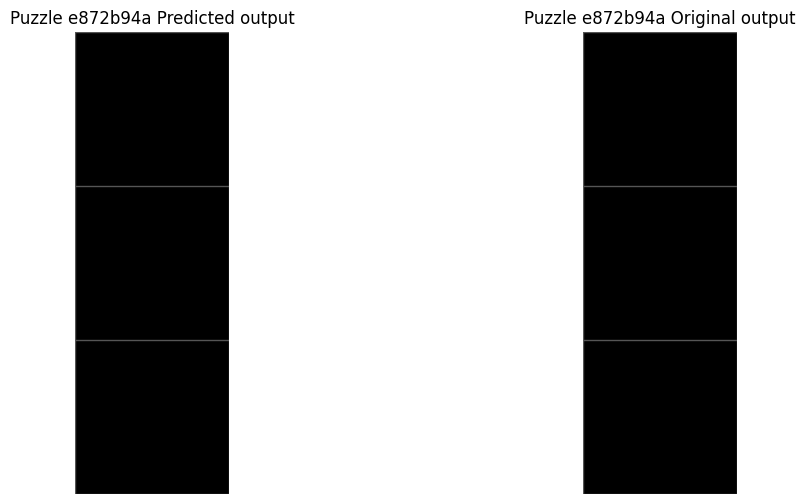

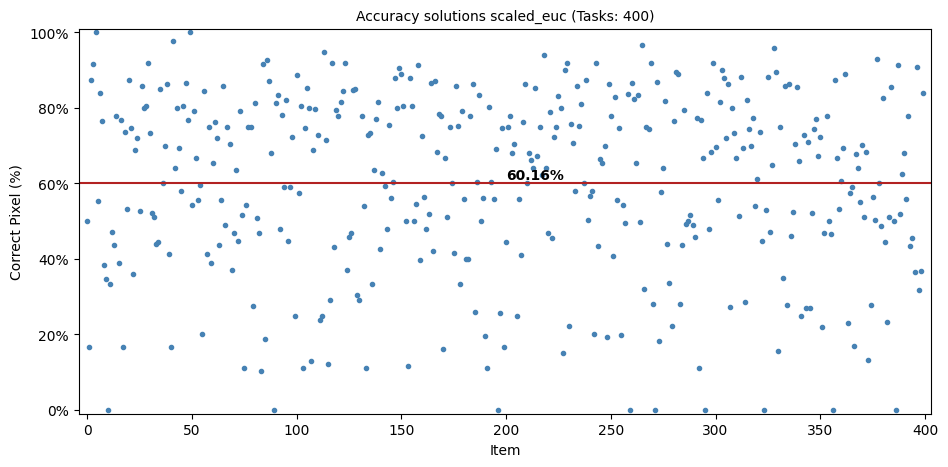

Number of 100% Correct: 2
Number of 90%+ Correct: 24
Number of 80%+ Correct: 95
Number of 70%+ Correct: 172
scaled_cos


/var/folders/x_/1hf63s3j2m7bc3xtjhjglm780000gn/T/ipykernel_48797/3099429816.py:84: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  z_pred = z_test_input + z_diff
/var/folders/x_/1hf63s3j2m7bc3xtjhjglm780000gn/T/ipykernel_48797/3099429816.py:84: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  z_pred = z_test_input + z_diff
/var/folders/x_/1hf63s3j2m7bc3xtjhjglm780000gn/T/ipykernel_48797/3099429816.py:84: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  z_pred = z_test_input + z_diff
/var/folders/x_/1hf63s3j2m7bc3xtjhjglm780000gn/T/ipykernel_48797/3099429816.py:84: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  z_pred = z_test_input +

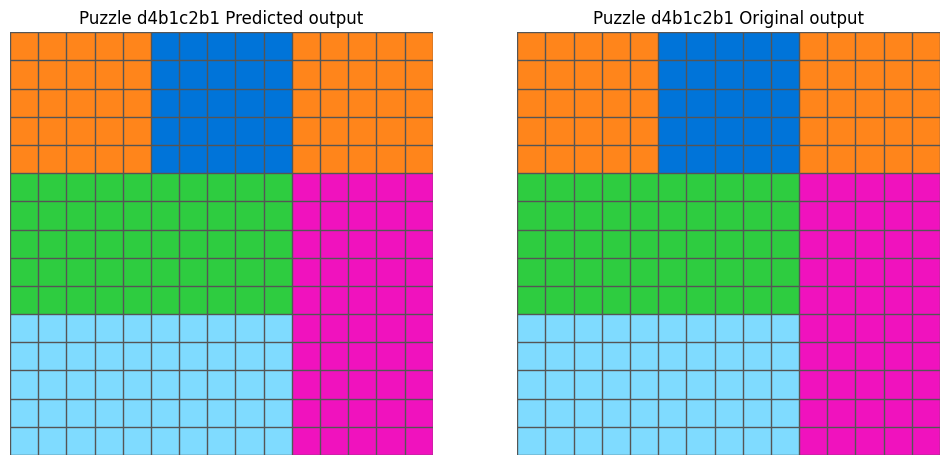

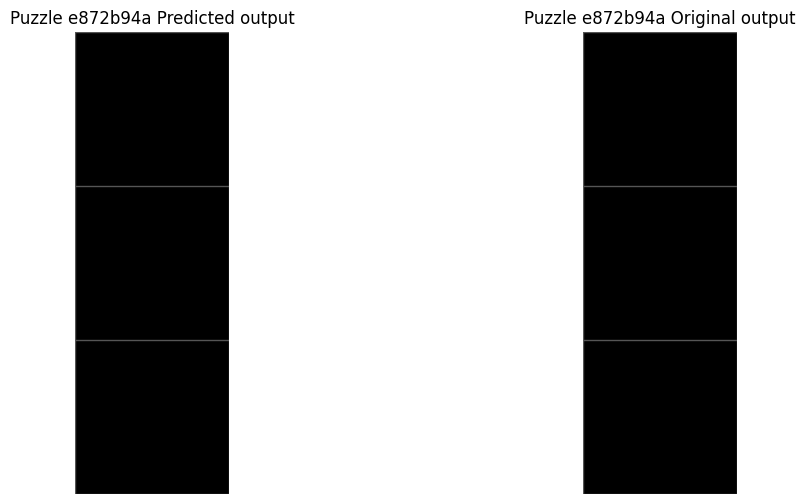

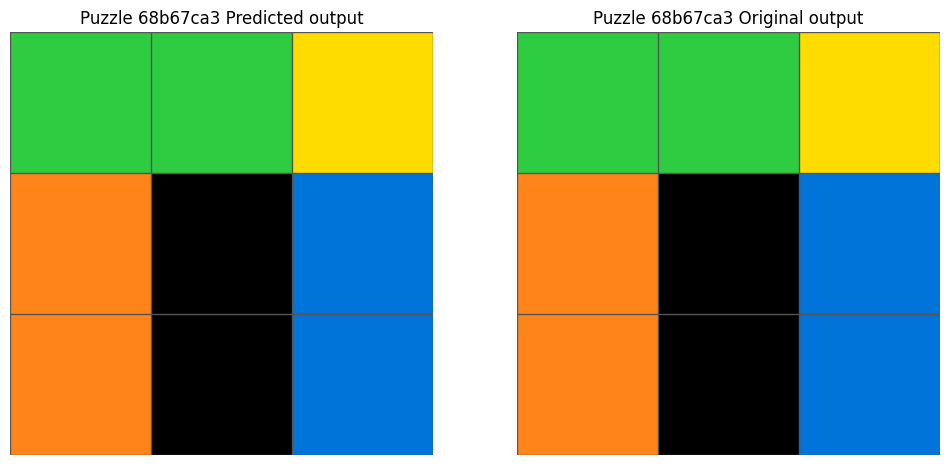

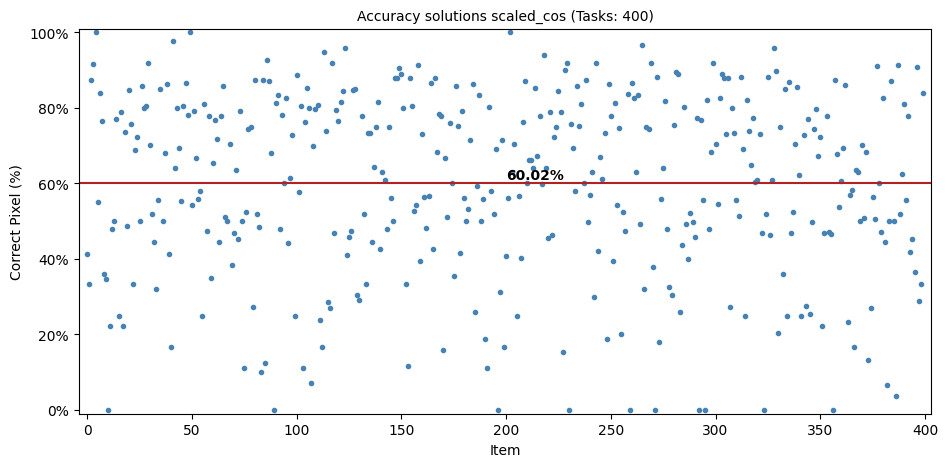

Number of 100% Correct: 3
Number of 90%+ Correct: 23
Number of 80%+ Correct: 98
Number of 70%+ Correct: 171
no_transform


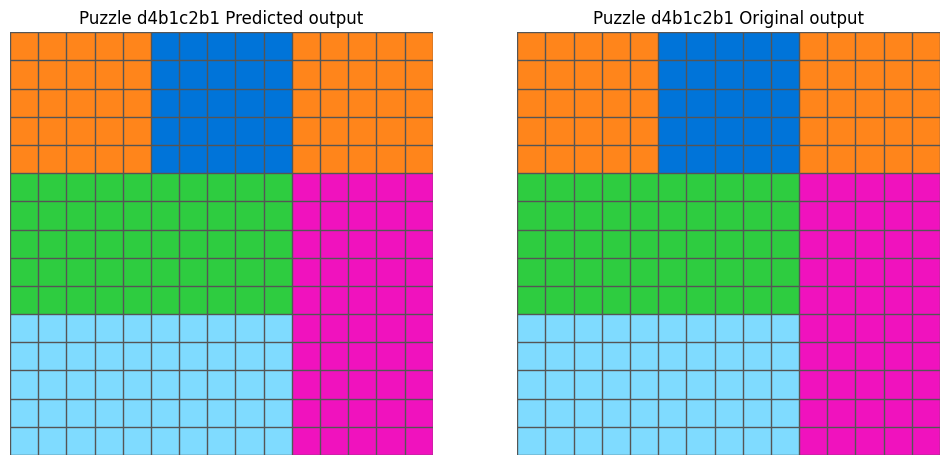

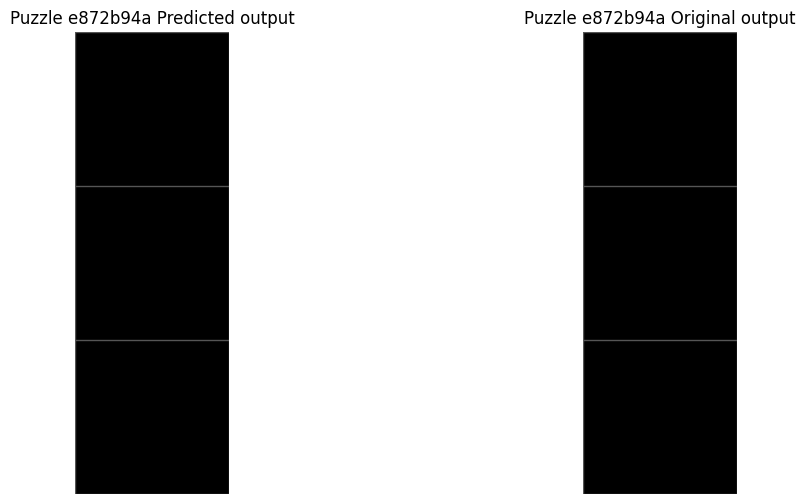

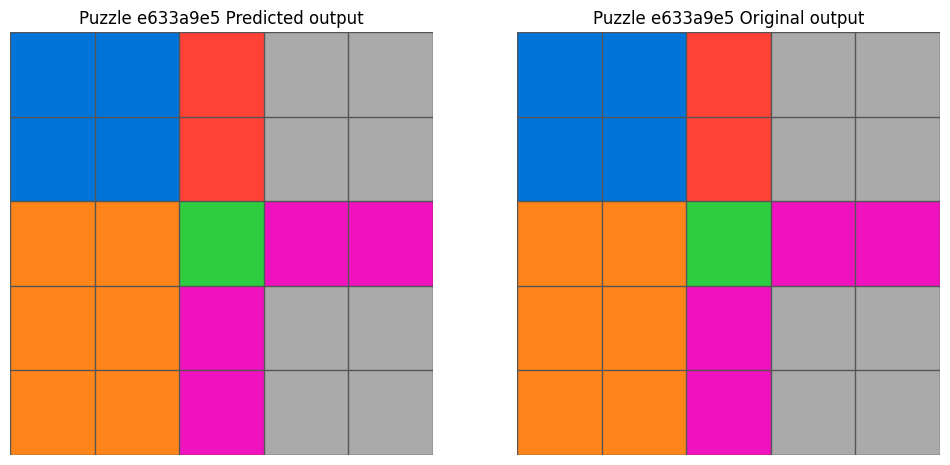

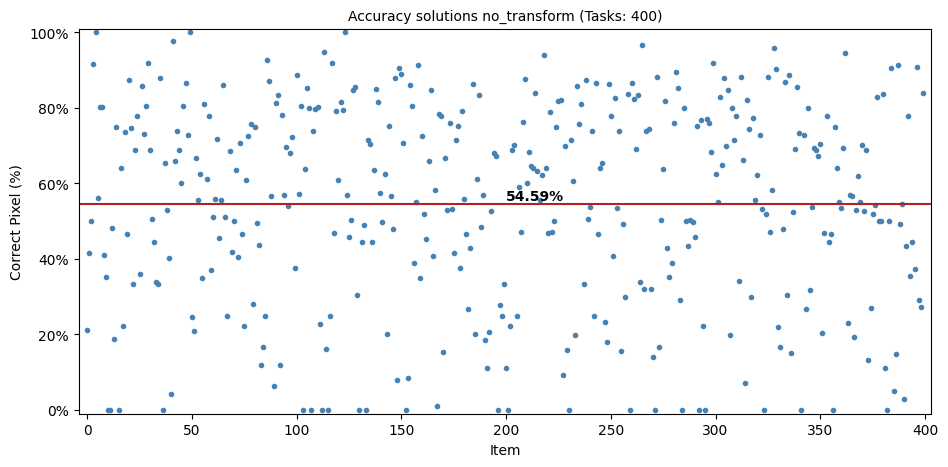

Number of 100% Correct: 3
Number of 90%+ Correct: 20
Number of 80%+ Correct: 81
Number of 70%+ Correct: 143


In [5]:
solved_puzzles = []

comps = ['average', 'scaled_euc', 'scaled_cos', 'no_transform']

def compute_accuracy(original, decoded):
        correct = (original == decoded)
        accuracy = correct.mean().item()
        is_perfect = accuracy == 1.0
        return accuracy, is_perfect

for comp in comps:
    print(comp)
    accuracies = []    

    for puzzle_id, task in data.items():
        
        pred, original = visual_analogy_single_task(
            pipeline=pipeline,
            train_pairs=task['train'],
            test_pair=task['test'][0],
            # model_type='vq',
            model_type='vae',
            comp=comp
        )

        acc, perfect = compute_accuracy(pred, original)
        accuracies.append(acc)

        if perfect:
            solved_puzzles.append(puzzle_id)

            fig, axes = plt.subplots(1, 2, figsize=(12, 6))
            draw_grid(axes[0], pred, f"Puzzle {puzzle_id} Predicted output")
            draw_grid(axes[1], original, f"Puzzle {puzzle_id} Original output")

    mean = np.mean(accuracies)

    ig, ax = plt.subplots(figsize=(11,5))
    plt.plot(accuracies, color='steelblue', marker='.', linewidth=0)
    plt.axhline(mean, xmax = len(accuracies), color='firebrick')
    plt.title(f'Accuracy solutions {comp} (Tasks: {len(accuracies)})', size='medium')
    plt.xlabel('Item')
    plt.ylabel('Correct Pixel (%)')
    plt.text(len(accuracies)/2, mean+0.01, f'{(mean*100).round(2)}%', size='medium', weight='bold')
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=max([1])))
    plt.ylim(-0.01, 1.01)
    plt.margins(x=0.01)
    plt.show()

    print(f'Number of 100% Correct: {accuracies.count(1)}')
    print(f'Number of 90%+ Correct: {sum(i >= 0.9 for i in accuracies)}')
    print(f'Number of 80%+ Correct: {sum(i >= 0.8 for i in accuracies)}')
    print(f'Number of 70%+ Correct: {sum(i >= 0.7 for i in accuracies)}')
        



In [ ]:
key='b7fb29bc'
pair = [([pair for pairs in data[key].values() for pair in pairs])[0]]
for (input, output) in pair:
    orig_input = input.copy()
    orig_output = output.copy()
    input = pipeline.preprocess_and_compress(input)
    output = pipeline.preprocess_and_compress(output)
    z_inp, _ = pipeline.encode(input.unsqueeze(0).to(device))
    z_out, _ = pipeline.encode(output.unsqueeze(0).to(device))

    x_inp = pipeline.decode(torch.tensor(z_inp, dtype=torch.float32).unsqueeze(0).to(device))
    x_inp = pipeline.decompress_and_postprocess(x_inp, orig_input)

    x_out = pipeline.decode(torch.tensor(z_out, dtype=torch.float32).unsqueeze(0).to(device))
    x_out = pipeline.decompress_and_postprocess(x_out, orig_output)
    
    fig, axes = plt.subplots(1, 4, figsize=(12, 6))
    draw_grid(axes[0], orig_input, f"Puzzle {key} Original Input")
    draw_grid(axes[1], x_inp, f"Puzzle {key} Reconstructed Input")
    draw_grid(axes[2], orig_output, f"Puzzle {key} Original Output")
    draw_grid(axes[3], x_out, f"Puzzle {key} Reconstructed Output")

In [ ]:
print(len(solved_puzzles))

In [ ]:
counter = 0
for puzzle_id, task in data.items():
    if counter >= 100:
        break

    test_pair = task['test'][0]
    
    counter += 1

    input_q, _ = test_pair

    input_w1 = pipeline.decompress_and_postprocess(pipeline.preprocess_and_compress(input_q), input_q)
    input_w2 = decompress_wavelet(compress_wavelet(preprocess_grid(input_q)))
    
    fig, axes = plt.subplots(1, 3, figsize=(12, 6))
    draw_grid(axes[0], input_q, f"Puzzle {puzzle_id} Original")
    draw_grid(axes[1], input_w1, f"Puzzle {puzzle_id} Predicted 1")
    draw_grid(axes[2], input_w2, f"Puzzle {puzzle_id} Predicted 2")

